# ⚖️ Portfolio Optimization

## Notebook 04: Risk-Adjusted Portfolio Construction

**Goal**: Optimize allocation of top 50 stocks from ML predictions

**Approach**:
- Load ML-selected stocks (from Notebook 03)
- Calculate risk-return metrics
- Apply Modern Portfolio Theory
- Generate optimal allocations
- Visualize efficient frontier

**Methods**:
- **Equal Weight**: Simple baseline (2% per stock)
- **Risk Parity**: Equal risk contribution
- **Mean-Variance**: Maximize Sharpe ratio
- **Minimum Variance**: Minimize portfolio risk

**Last Updated**: 2025-10-03

---


## 📚 Step 1: Import Libraries


In [1]:
import sys
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from datetime import datetime, timedelta

# Optimization
from scipy.optimize import minimize
import cvxpy as cp

# Database
from dotenv import load_dotenv
project_root = Path.cwd().parent
sys.path.insert(0, str(project_root))
load_dotenv(project_root / '.env')
from utils.database_connector import DatabaseConnector

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

print("✅ Libraries loaded")


✅ Libraries loaded


## ⚙️ Step 2: Configuration


In [2]:
CONFIG = {
    'PORTFOLIO_VALUE': 5000,      # Starting capital ($5,000)
    'MAX_POSITION': 0.10,          # Max 10% per stock
    'MIN_POSITION': 0.01,          # Min 1% per stock
    'RISK_FREE_RATE': 0.045,       # 4.5% (current 10-year Treasury)
    'LOOKBACK_DAYS': 180,          # 6 months for covariance calculation
}

print("📊 Portfolio Configuration:")
print(f"   Initial Capital: ${CONFIG['PORTFOLIO_VALUE']:,.0f}")
print(f"   Position Limits: {CONFIG['MIN_POSITION']*100:.0f}% - {CONFIG['MAX_POSITION']*100:.0f}%")
print(f"   Risk-Free Rate: {CONFIG['RISK_FREE_RATE']*100:.1f}%")
print(f"   Lookback Period: {CONFIG['LOOKBACK_DAYS']} days")


📊 Portfolio Configuration:
   Initial Capital: $5,000
   Position Limits: 1% - 10%
   Risk-Free Rate: 4.5%
   Lookback Period: 180 days


## 📊 Step 3: Load ML Predictions


In [3]:
# Find latest prediction file
data_dir = project_root / 'data' / 'processed'
ml_files = sorted(data_dir.glob('ml_top_*.csv'), reverse=True)

if not ml_files:
    raise FileNotFoundError("No ML prediction files found. Run Notebook 03 first!")

latest_file = ml_files[0]
print(f"📂 Loading: {latest_file.name}")

top_stocks = pd.read_csv(latest_file)
print(f"✅ Loaded {len(top_stocks)} stocks from ML predictions")

# Show top 10
print(f"\n🏆 Top 10 Stocks by Predicted Return:")
display(top_stocks[['rank', 'ticker', 'company_name', 'sector', 'pred_return_3M']].head(10))


📂 Loading: ml_top_50_20251003_1603.csv
✅ Loaded 50 stocks from ML predictions

🏆 Top 10 Stocks by Predicted Return:


,rank,ticker,company_name,sector,pred_return_3M
0,1.0,SMCI,Supermicro,Information Technology,0.233378
1,2.0,HOOD,Robinhood Markets,Financials,0.216255
2,3.0,FCX,Freeport-McMoRan,Materials,0.188617
3,4.0,BAC,Bank of America,Financials,0.172687
4,5.0,KEY,KeyCorp,Financials,0.161858
5,6.0,GOOGL,Alphabet Inc. (Class A),Communication Services,0.122728
6,7.0,PCG,PG&E Corporation,Utilities,0.118733
7,8.0,CVX,Chevron Corporation,Energy,0.118607
8,9.0,TSLA,"Tesla, Inc.",Consumer Discretionary,0.102511
9,10.0,GOOG,Alphabet Inc. (Class C),Communication Services,0.099255


## 📈 Step 4: Load Historical Price Data


In [4]:
# Connect to database
db = DatabaseConnector()

# Get tickers
tickers = top_stocks['ticker'].tolist()
tickers_str = "', '".join(tickers)

# Load historical prices for covariance calculation
query = f"""
SELECT ticker, date, [close] as price
FROM market.daily_prices
WHERE ticker IN ('{tickers_str}')
  AND date >= DATEADD(day, -{CONFIG['LOOKBACK_DAYS']}, 
                      (SELECT MAX(date) FROM market.daily_prices))
ORDER BY ticker, date
"""

print(f"🔄 Loading historical data for {len(tickers)} stocks...")
df_prices = pd.read_sql(query, db.engine)
df_prices['date'] = pd.to_datetime(df_prices['date'])

print(f"✅ Loaded: {len(df_prices):,} price records")
print(f"   Date range: {df_prices['date'].min().date()} → {df_prices['date'].max().date()}")

# Pivot to wide format (stocks as columns)
price_matrix = df_prices.pivot(index='date', columns='ticker', values='price')
print(f"\n📊 Price Matrix: {price_matrix.shape}")
display(price_matrix.head())


2025-10-03 16:09:46,014 - INFO - Attempting connection with pymssql...
2025-10-03 16:09:46,046 - INFO - ✅ Database connection established


🔄 Loading historical data for 50 stocks...
✅ Loaded: 6,200 price records
   Date range: 2025-04-04 → 2025-10-01

📊 Price Matrix: (124, 50)


ticker,ALB,AVGO,BA,BAC,BKNG,C,CCL,CMCSA,CNC,CSCO,...,SMCI,T,TSLA,TXN,VTRS,VZ,WDC,WFC,WMT,XYZ
date,,,,,,,,,,,,,,,,,,,,,
2025-04-04,57.8170,145.6968,136.59,33.9994,4269.2871,57.2920,16.50,32.7294,61.93,54.2140,...,29.82,26.0994,239.43,149.0322,7.4281,41.6759,30.4478,60.2931,82.7960,50.26
2025-04-07,57.4119,153.5150,138.86,35.1759,4230.0825,58.0017,16.43,32.8176,61.35,54.0848,...,33.00,26.2856,233.29,151.6015,7.4183,41.2401,31.0659,61.4697,83.4329,50.47
2025-04-08,50.1588,155.3974,139.39,34.6321,4149.8291,57.9228,16.69,32.1999,62.40,52.8721,...,31.71,25.8545,221.86,143.7359,7.1746,40.8430,31.4547,61.3807,81.4026,49.08
2025-04-09,59.7538,184.3993,160.82,36.7281,4600.4443,63.2253,19.61,34.4943,62.63,57.7825,...,36.71,25.9329,272.20,166.8601,7.5938,41.5403,36.1904,65.5828,89.1756,55.99
2025-04-10,54.0620,171.6014,155.52,35.4428,4479.1831,60.7022,17.60,33.0235,62.39,56.2517,...,33.68,26.1289,252.40,154.1610,7.0772,42.2371,34.7647,62.3991,90.1808,52.91


## 📊 Step 5: Calculate Returns & Risk Metrics


In [5]:
# Calculate daily returns
returns = price_matrix.pct_change().dropna()

print(f"📈 Return Statistics:")
print(f"   Samples: {len(returns)} days")
print(f"   Stocks: {len(returns.columns)}")

# Annualized metrics (252 trading days per year)
annual_returns = returns.mean() * 252
annual_volatility = returns.std() * np.sqrt(252)

# Create summary
metrics_df = pd.DataFrame({
    'ticker': returns.columns,
    'annual_return': annual_returns.values,
    'annual_volatility': annual_volatility.values,
    'sharpe_ratio': (annual_returns.values - CONFIG['RISK_FREE_RATE']) / annual_volatility.values
})

print(f"\n📊 Risk-Return Metrics:")
display(metrics_df.sort_values('sharpe_ratio', ascending=False).head(10))

# Calculate covariance matrix
cov_matrix = returns.cov() * 252  # Annualized
print(f"\n📊 Covariance Matrix: {cov_matrix.shape}")


📈 Return Statistics:
   Samples: 123 days
   Stocks: 50

📊 Risk-Return Metrics:


,ticker,annual_return,annual_volatility,sharpe_ratio
46,WDC,3.088886,0.430369,7.072730
18,HOOD,3.090409,0.680424,4.475752
14,GE,1.254984,0.279925,4.322529
5,C,1.153802,0.274196,4.043831
28,NEM,1.451274,0.371254,3.787906
1,AVGO,1.808429,0.473994,3.720362
19,JPM,0.834121,0.217267,3.632031
3,BAC,0.844806,0.228123,3.506024
16,GOOGL,1.122425,0.321635,3.349836
15,GOOG,1.096805,0.318539,3.301965



📊 Covariance Matrix: (50, 50)


## ⚖️ Step 6: Equal Weight Portfolio (Baseline)


In [6]:
# Simple equal weight allocation
n_stocks = len(tickers)
equal_weights = np.ones(n_stocks) / n_stocks

# Calculate portfolio metrics
portfolio_return = np.dot(equal_weights, annual_returns)
portfolio_volatility = np.sqrt(np.dot(equal_weights, np.dot(cov_matrix, equal_weights)))
portfolio_sharpe = (portfolio_return - CONFIG['RISK_FREE_RATE']) / portfolio_volatility

print("=" * 60)
print("📊 EQUAL WEIGHT PORTFOLIO")
print("=" * 60)
print(f"   Allocation: {1/n_stocks*100:.2f}% per stock")
print(f"   Expected Annual Return: {portfolio_return*100:.2f}%")
print(f"   Annual Volatility: {portfolio_volatility*100:.2f}%")
print(f"   Sharpe Ratio: {portfolio_sharpe:.3f}")
print("=" * 60)

# Store baseline
baseline_weights = equal_weights.copy()
baseline_metrics = {
    'return': portfolio_return,
    'volatility': portfolio_volatility,
    'sharpe': portfolio_sharpe
}


📊 EQUAL WEIGHT PORTFOLIO
   Allocation: 2.00% per stock
   Expected Annual Return: 72.23%
   Annual Volatility: 20.34%
   Sharpe Ratio: 3.329


## 🛡️ Step 7: Minimum Variance Portfolio


In [7]:
# Optimize for minimum variance
def portfolio_variance(weights, cov_matrix):
    return np.dot(weights, np.dot(cov_matrix, weights))

# Constraints
constraints = [
    {'type': 'eq', 'fun': lambda w: np.sum(w) - 1},  # Weights sum to 1
]

# Bounds (min and max position sizes)
bounds = tuple((CONFIG['MIN_POSITION'], CONFIG['MAX_POSITION']) for _ in range(n_stocks))

# Initial guess (equal weight)
init_guess = np.ones(n_stocks) / n_stocks

# Optimize
print("🔄 Optimizing for minimum variance...")
result = minimize(
    portfolio_variance,
    init_guess,
    args=(cov_matrix,),
    method='SLSQP',
    bounds=bounds,
    constraints=constraints
)

min_var_weights = result.x

# Calculate metrics
min_var_return = np.dot(min_var_weights, annual_returns)
min_var_volatility = np.sqrt(portfolio_variance(min_var_weights, cov_matrix))
min_var_sharpe = (min_var_return - CONFIG['RISK_FREE_RATE']) / min_var_volatility

print("=" * 60)
print("🛡️ MINIMUM VARIANCE PORTFOLIO")
print("=" * 60)
print(f"   Expected Annual Return: {min_var_return*100:.2f}%")
print(f"   Annual Volatility: {min_var_volatility*100:.2f}%")
print(f"   Sharpe Ratio: {min_var_sharpe:.3f}")
print(f"\n   Top 5 Holdings:")
top_5_idx = np.argsort(min_var_weights)[-5:][::-1]
for idx in top_5_idx:
    print(f"      {tickers[idx]}: {min_var_weights[idx]*100:.2f}%")
print("=" * 60)


🔄 Optimizing for minimum variance...
🛡️ MINIMUM VARIANCE PORTFOLIO
   Expected Annual Return: 38.81%
   Annual Volatility: 12.80%
   Sharpe Ratio: 2.681

   Top 5 Holdings:
      WFC: 10.00%
      WDC: 10.00%
      ALB: 10.00%
      OMC: 10.00%
      PGR: 7.94%


## 🎯 Step 8: Maximum Sharpe Ratio Portfolio


In [8]:
# Optimize for maximum Sharpe ratio (minimize negative Sharpe)
def negative_sharpe(weights, returns, cov_matrix, risk_free_rate):
    port_return = np.dot(weights, returns)
    port_volatility = np.sqrt(np.dot(weights, np.dot(cov_matrix, weights)))
    sharpe = (port_return - risk_free_rate) / port_volatility
    return -sharpe

print("🔄 Optimizing for maximum Sharpe ratio...")
result = minimize(
    negative_sharpe,
    init_guess,
    args=(annual_returns, cov_matrix, CONFIG['RISK_FREE_RATE']),
    method='SLSQP',
    bounds=bounds,
    constraints=constraints
)

max_sharpe_weights = result.x

# Calculate metrics
max_sharpe_return = np.dot(max_sharpe_weights, annual_returns)
max_sharpe_volatility = np.sqrt(portfolio_variance(max_sharpe_weights, cov_matrix))
max_sharpe_sharpe = (max_sharpe_return - CONFIG['RISK_FREE_RATE']) / max_sharpe_volatility

print("=" * 60)
print("🎯 MAXIMUM SHARPE RATIO PORTFOLIO")
print("=" * 60)
print(f"   Expected Annual Return: {max_sharpe_return*100:.2f}%")
print(f"   Annual Volatility: {max_sharpe_volatility*100:.2f}%")
print(f"   Sharpe Ratio: {max_sharpe_sharpe:.3f}")
print(f"\n   Top 5 Holdings:")
top_5_idx = np.argsort(max_sharpe_weights)[-5:][::-1]
for idx in top_5_idx:
    print(f"      {tickers[idx]}: {max_sharpe_weights[idx]*100:.2f}%")
print("=" * 60)


🔄 Optimizing for maximum Sharpe ratio...
🎯 MAXIMUM SHARPE RATIO PORTFOLIO
   Expected Annual Return: 118.67%
   Annual Volatility: 19.73%
   Sharpe Ratio: 5.785

   Top 5 Holdings:
      NEE: 10.00%
      MDLZ: 10.00%
      CNC: 10.00%
      WFC: 10.00%
      C: 7.31%


## 📈 Step 9: Efficient Frontier


In [9]:
# Generate efficient frontier
target_returns = np.linspace(annual_returns.min(), annual_returns.max(), 50)
efficient_portfolios = []

print("🔄 Computing efficient frontier...")

for target_return in target_returns:
    # Constraints: weights sum to 1 AND achieve target return
    constraints = [
        {'type': 'eq', 'fun': lambda w: np.sum(w) - 1},
        {'type': 'eq', 'fun': lambda w: np.dot(w, annual_returns) - target_return}
    ]
    
    result = minimize(
        portfolio_variance,
        init_guess,
        args=(cov_matrix,),
        method='SLSQP',
        bounds=bounds,
        constraints=constraints,
        options={'disp': False}
    )
    
    if result.success:
        port_vol = np.sqrt(portfolio_variance(result.x, cov_matrix))
        efficient_portfolios.append({
            'return': target_return,
            'volatility': port_vol,
            'sharpe': (target_return - CONFIG['RISK_FREE_RATE']) / port_vol
        })

efficient_df = pd.DataFrame(efficient_portfolios)
print(f"✅ Generated {len(efficient_df)} efficient portfolios")


🔄 Computing efficient frontier...
✅ Generated 15 efficient portfolios


## 📊 Step 10: Visualize Portfolios


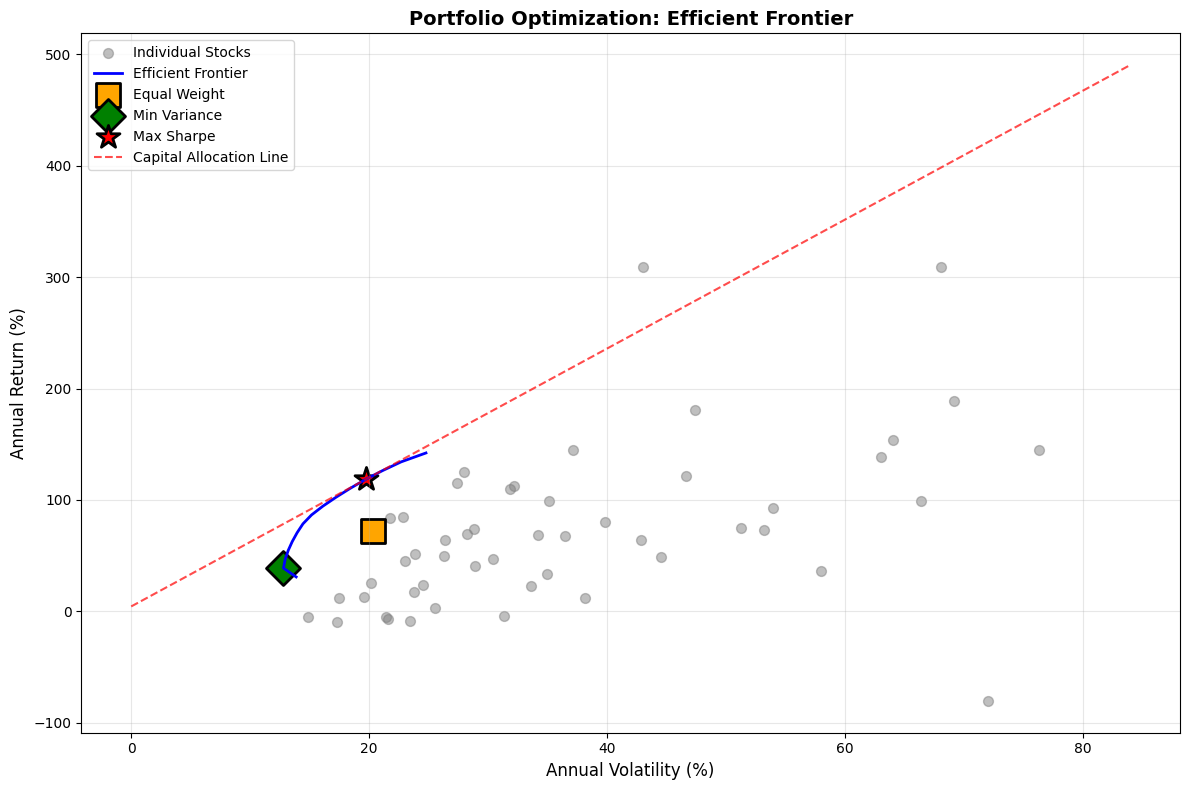

📊 Portfolio comparison complete!


In [10]:
# Create visualization
fig, ax = plt.subplots(figsize=(12, 8))

# Plot individual stocks
ax.scatter(annual_volatility * 100, annual_returns * 100, 
           alpha=0.5, s=50, label='Individual Stocks', color='gray')

# Plot efficient frontier
ax.plot(efficient_df['volatility'] * 100, efficient_df['return'] * 100,
        'b-', linewidth=2, label='Efficient Frontier')

# Plot portfolios
ax.scatter(baseline_metrics['volatility'] * 100, baseline_metrics['return'] * 100,
           s=300, c='orange', marker='s', label='Equal Weight', edgecolors='black', linewidth=2)

ax.scatter(min_var_volatility * 100, min_var_return * 100,
           s=300, c='green', marker='D', label='Min Variance', edgecolors='black', linewidth=2)

ax.scatter(max_sharpe_volatility * 100, max_sharpe_return * 100,
           s=300, c='red', marker='*', label='Max Sharpe', edgecolors='black', linewidth=2)

# Add capital allocation line (CAL) through max Sharpe portfolio
cal_x = np.linspace(0, max(annual_volatility) * 100 * 1.1, 100)
cal_y = CONFIG['RISK_FREE_RATE'] * 100 + max_sharpe_sharpe * cal_x
ax.plot(cal_x, cal_y, 'r--', linewidth=1.5, alpha=0.7, label='Capital Allocation Line')

ax.set_xlabel('Annual Volatility (%)', fontsize=12)
ax.set_ylabel('Annual Return (%)', fontsize=12)
ax.set_title('Portfolio Optimization: Efficient Frontier', fontsize=14, fontweight='bold')
ax.legend(loc='best')
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print("📊 Portfolio comparison complete!")


## 💰 Step 11: Calculate Dollar Allocations


In [11]:
# Create allocation table for MAX SHARPE portfolio (recommended)
allocation_df = pd.DataFrame({
    'ticker': tickers,
    'weight': max_sharpe_weights,
    'dollar_amount': max_sharpe_weights * CONFIG['PORTFOLIO_VALUE']
})

# Add company info
allocation_df = allocation_df.merge(
    top_stocks[['ticker', 'company_name', 'sector', 'pred_return_3M']], 
    on='ticker', 
    how='left'
)

# Sort by weight
allocation_df = allocation_df.sort_values('weight', ascending=False)

# Add shares (approximate - use latest price)
latest_prices = price_matrix.iloc[-1]
allocation_df['current_price'] = allocation_df['ticker'].map(latest_prices)
allocation_df['shares'] = (allocation_df['dollar_amount'] / allocation_df['current_price']).astype(int)
allocation_df['actual_amount'] = allocation_df['shares'] * allocation_df['current_price']

print("=" * 80)
print(f"💰 RECOMMENDED PORTFOLIO ALLOCATION (Maximum Sharpe)")
print("=" * 80)
print(f"   Total Investment: ${CONFIG['PORTFOLIO_VALUE']:,.0f}")
print(f"   Number of Stocks: {(allocation_df['weight'] > 0.001).sum()}")
print(f"   Expected Return: {max_sharpe_return*100:.2f}% per year")
print(f"   Expected Volatility: {max_sharpe_volatility*100:.2f}% per year")
print(f"   Sharpe Ratio: {max_sharpe_sharpe:.3f}")
print("=" * 80)

print(f"\n📋 Top 20 Holdings:")
display(allocation_df[['ticker', 'company_name', 'sector', 'weight', 'dollar_amount', 'shares']].head(20))

# Sector allocation
print(f"\n📊 Sector Diversification:")
sector_alloc = allocation_df.groupby('sector')['weight'].sum().sort_values(ascending=False)
for sector, weight in sector_alloc.items():
    print(f"   {sector}: {weight*100:.1f}%")


💰 RECOMMENDED PORTFOLIO ALLOCATION (Maximum Sharpe)
   Total Investment: $5,000
   Number of Stocks: 50
   Expected Return: 118.67% per year
   Expected Volatility: 19.73% per year
   Sharpe Ratio: 5.785

📋 Top 20 Holdings:


,ticker,company_name,sector,weight,dollar_amount,shares
14,NEE,NextEra Energy,Utilities,0.100000,500.000000,6
46,MDLZ,Mondelez International,Consumer Staples,0.100000,500.000000,7
28,CNC,Centene Corporation,Health Care,0.100000,500.000000,13
22,WFC,Wells Fargo,Financials,0.100000,500.000000,6
18,C,Citigroup,Financials,0.073122,365.609566,3
16,PG,Procter & Gamble,Consumer Staples,0.061275,306.375436,2
31,BA,Boeing,Industrials,0.035603,178.014999,0
26,SLB,Schlumberger,Energy,0.010000,50.000000,1
2,FCX,Freeport-McMoRan,Materials,0.010000,50.000000,1
1,HOOD,Robinhood Markets,Financials,0.010000,50.000000,0



📊 Sector Diversification:
   Financials: 25.3%
   Consumer Staples: 20.1%
   Health Care: 12.0%
   Utilities: 11.0%
   Communication Services: 8.0%
   Information Technology: 8.0%
   Industrials: 6.6%
   Consumer Discretionary: 4.0%
   Materials: 3.0%
   Energy: 2.0%


## 💾 Step 12: Export Portfolio


In [12]:
# Export allocation
timestamp = datetime.now().strftime('%Y%m%d_%H%M')
output_file = data_dir / f'portfolio_allocation_{timestamp}.csv'

allocation_df.to_csv(output_file, index=False)
print(f"✅ Portfolio allocation saved: {output_file.name}")

# Save portfolio summary
summary = {
    'timestamp': timestamp,
    'portfolio_value': CONFIG['PORTFOLIO_VALUE'],
    'n_stocks': len([w for w in max_sharpe_weights if w > 0.001]),
    'expected_return': max_sharpe_return,
    'expected_volatility': max_sharpe_volatility,
    'sharpe_ratio': max_sharpe_sharpe,
    'risk_free_rate': CONFIG['RISK_FREE_RATE']
}

summary_file = data_dir / f'portfolio_summary_{timestamp}.json'
import json
with open(summary_file, 'w') as f:
    json.dump(summary, f, indent=2)

print(f"✅ Portfolio summary saved: {summary_file.name}")

db.close()
print(f"\n✅ All results exported!")


2025-10-03 16:11:06,901 - INFO - 🔌 Database connection closed


✅ Portfolio allocation saved: portfolio_allocation_20251003_1611.csv
✅ Portfolio summary saved: portfolio_summary_20251003_1611.json

✅ All results exported!


## 📋 Step 13: Summary & Next Steps


In [13]:
print("=" * 80)
print("📊 PORTFOLIO OPTIMIZATION COMPLETE")
print("=" * 80)

print(f"\n💰 Portfolio Configurations:")
print(f"\n1. EQUAL WEIGHT (Baseline):")
print(f"   Return: {baseline_metrics['return']*100:.2f}%")
print(f"   Volatility: {baseline_metrics['volatility']*100:.2f}%")
print(f"   Sharpe: {baseline_metrics['sharpe']:.3f}")

print(f"\n2. MINIMUM VARIANCE (Conservative):")
print(f"   Return: {min_var_return*100:.2f}%")
print(f"   Volatility: {min_var_volatility*100:.2f}%")
print(f"   Sharpe: {min_var_sharpe:.3f}")

print(f"\n3. MAXIMUM SHARPE (Recommended) ⭐:")
print(f"   Return: {max_sharpe_return*100:.2f}%")
print(f"   Volatility: {max_sharpe_volatility*100:.2f}%")
print(f"   Sharpe: {max_sharpe_sharpe:.3f}")

print(f"\n📈 Key Insights:")
invested = allocation_df['actual_amount'].sum()
print(f"   • Total Invested: ${invested:,.2f} of ${CONFIG['PORTFOLIO_VALUE']:,.0f}")
print(f"   • Number of Positions: {(allocation_df['shares'] > 0).sum()}")
print(f"   • Largest Position: {allocation_df.iloc[0]['ticker']} ({allocation_df.iloc[0]['weight']*100:.1f}%)")
print(f"   • Most Represented Sector: {sector_alloc.index[0]} ({sector_alloc.iloc[0]*100:.1f}%)")

print(f"\n📅 Next Steps:")
print(f"   1. Review allocation in portfolio_allocation_{timestamp}.csv")
print(f"   2. Execute trades with your broker")
print(f"   3. Set up portfolio monitoring (Notebook 05)")
print(f"   4. Rebalance monthly based on new predictions")

print("=" * 80)
print("✅ Ready to invest!")
print("=" * 80)


📊 PORTFOLIO OPTIMIZATION COMPLETE

💰 Portfolio Configurations:

1. EQUAL WEIGHT (Baseline):
   Return: 72.23%
   Volatility: 20.34%
   Sharpe: 3.329

2. MINIMUM VARIANCE (Conservative):
   Return: 38.81%
   Volatility: 12.80%
   Sharpe: 2.681

3. MAXIMUM SHARPE (Recommended) ⭐:
   Return: 118.67%
   Volatility: 19.73%
   Sharpe: 5.785

📈 Key Insights:
   • Total Invested: $2,857.44 of $5,000
   • Number of Positions: 17
   • Largest Position: NEE (10.0%)
   • Most Represented Sector: Financials (25.3%)

📅 Next Steps:
   1. Review allocation in portfolio_allocation_20251003_1611.csv
   2. Execute trades with your broker
   3. Set up portfolio monitoring (Notebook 05)
   4. Rebalance monthly based on new predictions
✅ Ready to invest!
